In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

try:
    from recognition.ocr.utils.iam_dataset import IAMDataset
except:
    try:
        from handwritten_text_recognition.recognition.ocr.utils.iam_dataset import IAMDataset
    except:
        from recognition.handwritten_text_recognition.recognition.ocr.utils.iam_dataset import IAMDataset

# Paragraph Segmentation
This notebook investigates methods to identify segment passages from images that contains printed and handwritten text using the **MSER algorithm**.

*Input*: a png from the IAM dataset with the "form" input and output type of "bb" and form.

*Output*: a bounding boxes of the paragraphs.

## Dataset creation

In [2]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Processing data:
Completed: [--------------------------------------- ]  99%Number of training samples: 967
Number of testing samples: 232


## MSER based text region detection

The MSER algorithm has been used in text regions detection [1]. Although this was mainly applied to printed text, we tested this technique to segment documents with both handwritten and printed text.

### Detecting text region proposals

In [3]:
def get_text_region_proposals(image, min_area=30, max_area=500, delta=3):
    '''
    Source: https://stackoverflow.com/questions/34398188/trying-to-plot-opencvs-mser-regions-using-matplotlib
    
    Parameters
    ----------
    
    min_area: int, default 30
        Suggested value: ~[5 - 50]
    
    max_area: int, default 500
        Suggested value: ~[500 - 800]

    delta: int, default 3
        Suggested value: ~[1-5]
    
    '''
    mser = cv2.MSER_create()
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    mser.setDelta(delta)

    coordinates, _ = mser.detectRegions(image)
    
    bbs = []
    for coord in coordinates:
        bbox = cv2.boundingRect(coord)
        x, y, w, h = bbox
        if w < 10 or h < 10 or w/h > 5 or h/w > 5:
            continue
        bbs.append((x, y, w, h))
    return bbs

In [4]:
image, _ = train_ds[0]

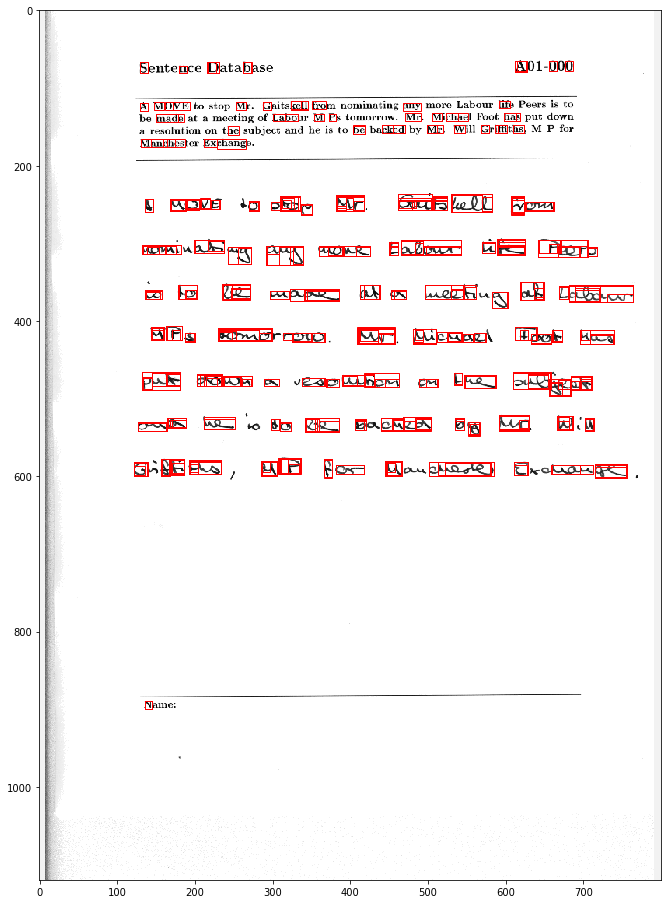

In [5]:
fig, ax = plt.subplots(1, figsize=(18, 16))
bbs = get_text_region_proposals(image)
ax.imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    ax.add_patch(rect)
display.display(plt.gcf())
display.clear_output(wait=True)

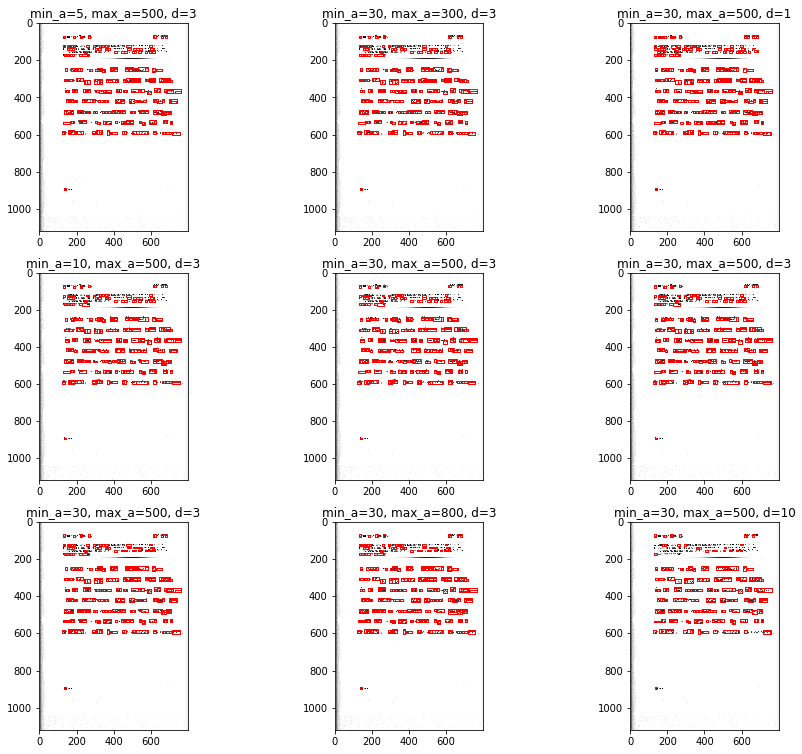

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(15, 13))

min_a, max_a, d = "min_area", "max_area", "delta"

parameters = [[{min_a:5, max_a:500, d:3}, {min_a:30, max_a:300, d:3}, {min_a:30, max_a:500, d:1}],
              [{min_a:10, max_a:500, d:3}, {min_a:30, max_a:500, d:3}, {min_a:30, max_a:500, d:3}],
              [{min_a:30, max_a:500, d:3}, {min_a:30, max_a:800, d:3}, {min_a:30, max_a:500, d:10}]]

for parameter_i, ax_i in zip(parameters, axs): 
    for parameter, ax in zip(parameter_i, ax_i): 
        bbs = get_text_region_proposals(image, **parameter)
        ax.imshow(image, cmap='Greys_r')
        ax.set_title("min_a={}, max_a={}, d={}".format(
            parameter[min_a], parameter[max_a],parameter[d]))
        for (x, y, w, h) in bbs:
            rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
            ax.add_patch(rect)

display.display(plt.gcf())
display.clear_output(wait=True)

### Detecting boundings of passages
Algorithm:

Parameters:
- IOU_threshold
- dilation_d

While:
1. Dilate all bbs by dilation_d
2. find all bbs that are overlapped more than the IOU_threshold and merge them into 1 bb
3. if no new bbs are formed, break

In [7]:
def dilate_bbs(bbs, dilation_d, dilation_max):
    bbs_l = []
    for bb in bbs:
        (x, y, w, h) = bb
        (centre_x, centre_y) = (x + w/2, y + h/2)
        (x1, y1, x2, y2) = (x, y, x + w, y + h)

        dx = (centre_x - x1) * dilation_d
        dy = (centre_y - y1) * dilation_d
        
        if dilation_max:
            if dx > dilation_max[0]:
                dx = dilation_max[0]
            if dy > dilation_max[1]:
                dy = dilation_max[1]

        x1_l = centre_x - dx
        y1_l = centre_y - dy
        x2_l = centre_x + dx
        y2_l = centre_y + dy

        bb_l = (int(x1_l), int(y1_l), int(x2_l - x1_l), int(y2_l - y1_l))
        bbs_l.append(bb_l)
    return bbs_l
 
def does_rect_overlap(bb1, bb2):
    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)
    
    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    h_overlaps = True
    v_overlaps = True
    if (x1_1 > x2_2) or (x2_1 < x1_2):
        h_overlaps = False
    if (y1_1 > y2_2) or (y2_1 < y1_2):
        v_overlaps = False
    return h_overlaps and v_overlaps

def get_intersection_percentage(bb1, bb2):
    # How much of bb1 is intersecting with bb2
    if not does_rect_overlap(bb1, bb2):
        return 0
    # source: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)
    
    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    x_a = max(x1_1, x1_2)
    y_a = max(y1_1, y1_2)
    x_b = min(x2_1, x2_2)
    y_b = min(y2_1, y2_2)
 
    inter_area = (x_b - x_a + 1) * (y_b - y_a + 1)
 
    bb1_area = (w_1 + 1) * (h_1 + 1)
    bb2_area = (w_2 + 1) * (h_2 + 1)
 
    intersection_percentage = inter_area / float(bb1_area)
    return intersection_percentage

def get_intersection_percentage_matrix(bbs):
    n = len(bbs)
    ip = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            ip[i, j] = get_intersection_percentage(bbs[i], bbs[j])
    return ip 

def make_new_bb_from_intersect_bbs(bbs):
    max_x = np.max([bb[0] + bb[2] for bb in bbs])
    min_x = np.min([bb[0] for bb in bbs])
    max_y = np.max([bb[1] + bb[3] for bb in bbs])
    min_y = np.min([bb[1] for bb in bbs])
    return (min_x, min_y, max_x - min_x, max_y - min_y)

def reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded):
    new_bbs = []
    for i in range(in_matrix_thresholded.shape[0]):
        in_i = in_matrix_thresholded[i, :]
        intersections_indexes = np.where(in_i)[0]
        if len(intersections_indexes) == 0:
            new_bbs.append(bbs[i])
        else:
            intersection_bbs = [bbs[i]]
            for intersections_index in intersections_indexes:
                intersection_bbs.append(bbs[intersections_index])
            new_bb = make_new_bb_from_intersect_bbs(intersection_bbs)
            if new_bb not in new_bbs:
                new_bbs.append(new_bb)
    return new_bbs

'''
def contains(bb1, bb2):
    # bb2 is in bb1
    # source: https://stackoverflow.com/questions/21275714/check-rectangle-inside-rectangle-in-python
    in_x = bb1[0] < bb2[0] < bb2[0] + bb2[2] < bb1[0] + bb1[2]
    in_y = bb1[1] < bb2[1] < bb2[1] + bb2[3] < bb1[1] + bb1[3]
    return in_x and in_y

def remove_bbs_in_another_bb(bbs):
    new_bbs = []
    for i in range(len(bbs)):
        should_output_i = True
        bb_i = bbs[i]
        for j in range(len(bbs)):
            bb_j = bbs[j]
            if contains(bb_j, bb_i):
                should_output_i = False
                break
        if should_output_i:
            new_bbs.append(bb_i)
    return new_bbs
'''

def reduce_intersecting_bbs(bbs, intersection_threshold):
    new_bbs = bbs
    while True:
        old_bbs_no = len(bbs)
        in_matrix = get_intersection_percentage_matrix(bbs)
        in_matrix_thresholded = in_matrix > intersection_threshold
        bbs = reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded)
        if old_bbs_no == len(bbs):
            break
    return bbs

def get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max=None,
                                  intermetiate_bbs=None):
    '''    
    Parameters
    ----------
    iterations: int

    ios_threshold: 

    dilation_d: float
        percentage to increase the bounding box

    '''
    for i in range(iterations):
        bbs = dilate_bbs(bbs, dilation_d, dilation_max)
        bbs = reduce_intersecting_bbs(bbs, ip_threshold)
        if intermetiate_bbs is not None:
            intermetiate_bbs.append(bbs)
        print("Running {}/{}, new #bbs {}".format(i, iterations, len(bbs)))
    return bbs

#### Testing dilation

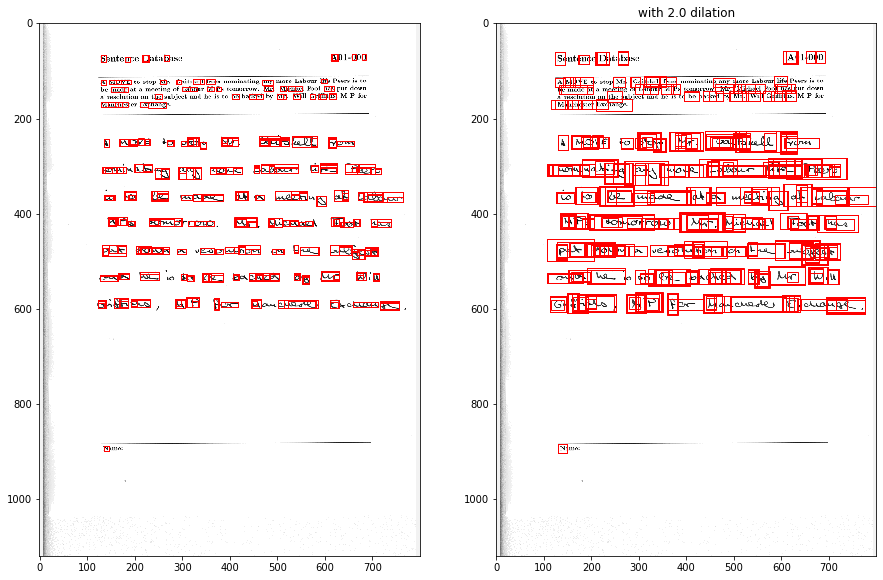

In [8]:
dilation_d = 2.0

image, _ = train_ds[0]

bbs = get_text_region_proposals(image)
bbs_l = dilate_bbs(bbs, dilation_d, None)
fig, axs = plt.subplots(1, 2, figsize=(15, 13))

axs[0].imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[0].add_patch(rect)
axs[1].imshow(image, cmap='Greys_r')
axs[1].set_title("with {} dilation".format(dilation_d))
for (x, y, w, h) in bbs_l:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[1].add_patch(rect)

#### Testing intersections

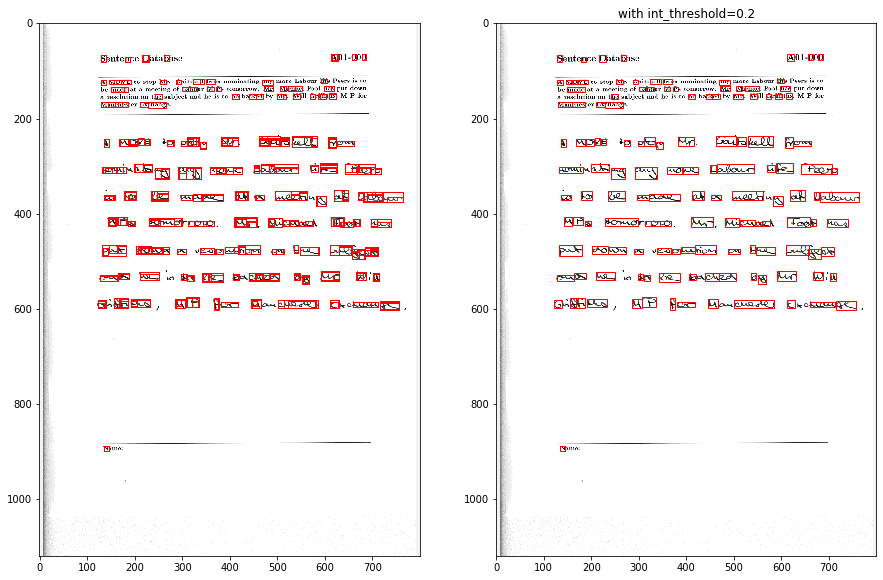

In [9]:
intersection_threshold = 0.2

image, _ = train_ds[0]

bbs = get_text_region_proposals(image)
bbs_l = reduce_intersecting_bbs(bbs, intersection_threshold)

fig, axs = plt.subplots(1, 2, figsize=(15, 13))

axs[0].imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[0].add_patch(rect)
axs[1].imshow(image, cmap='Greys_r')
axs[1].set_title("with int_threshold={}".format(intersection_threshold))
for (x, y, w, h) in bbs_l:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[1].add_patch(rect)

# Passage bounding boxes detection

In [10]:
def plot_intermediate_bbs(intermetiate_bbs, iterations):
    fig, axs = plt.subplots(1, iterations, figsize=(12 * iterations, 15))
    for i, bb in enumerate(intermetiate_bbs):
        axs[i].imshow(image, cmap='Greys_r')
        for (x, y, w, h) in bb:
            rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
            axs[i].add_patch(rect)
        axs[i].set_title("At iteration={} #bbs {}".format(i+1, len(bb)))
        axs[i].imshow(image, cmap='Greys_r')

After careful tuning of the parameters (#iterations, dilation, intersection threshold), segmentation of the passages can be obtained. Three examples are shown below.

Running 0/3, new #bbs 116
Running 1/3, new #bbs 100
Running 2/3, new #bbs 92


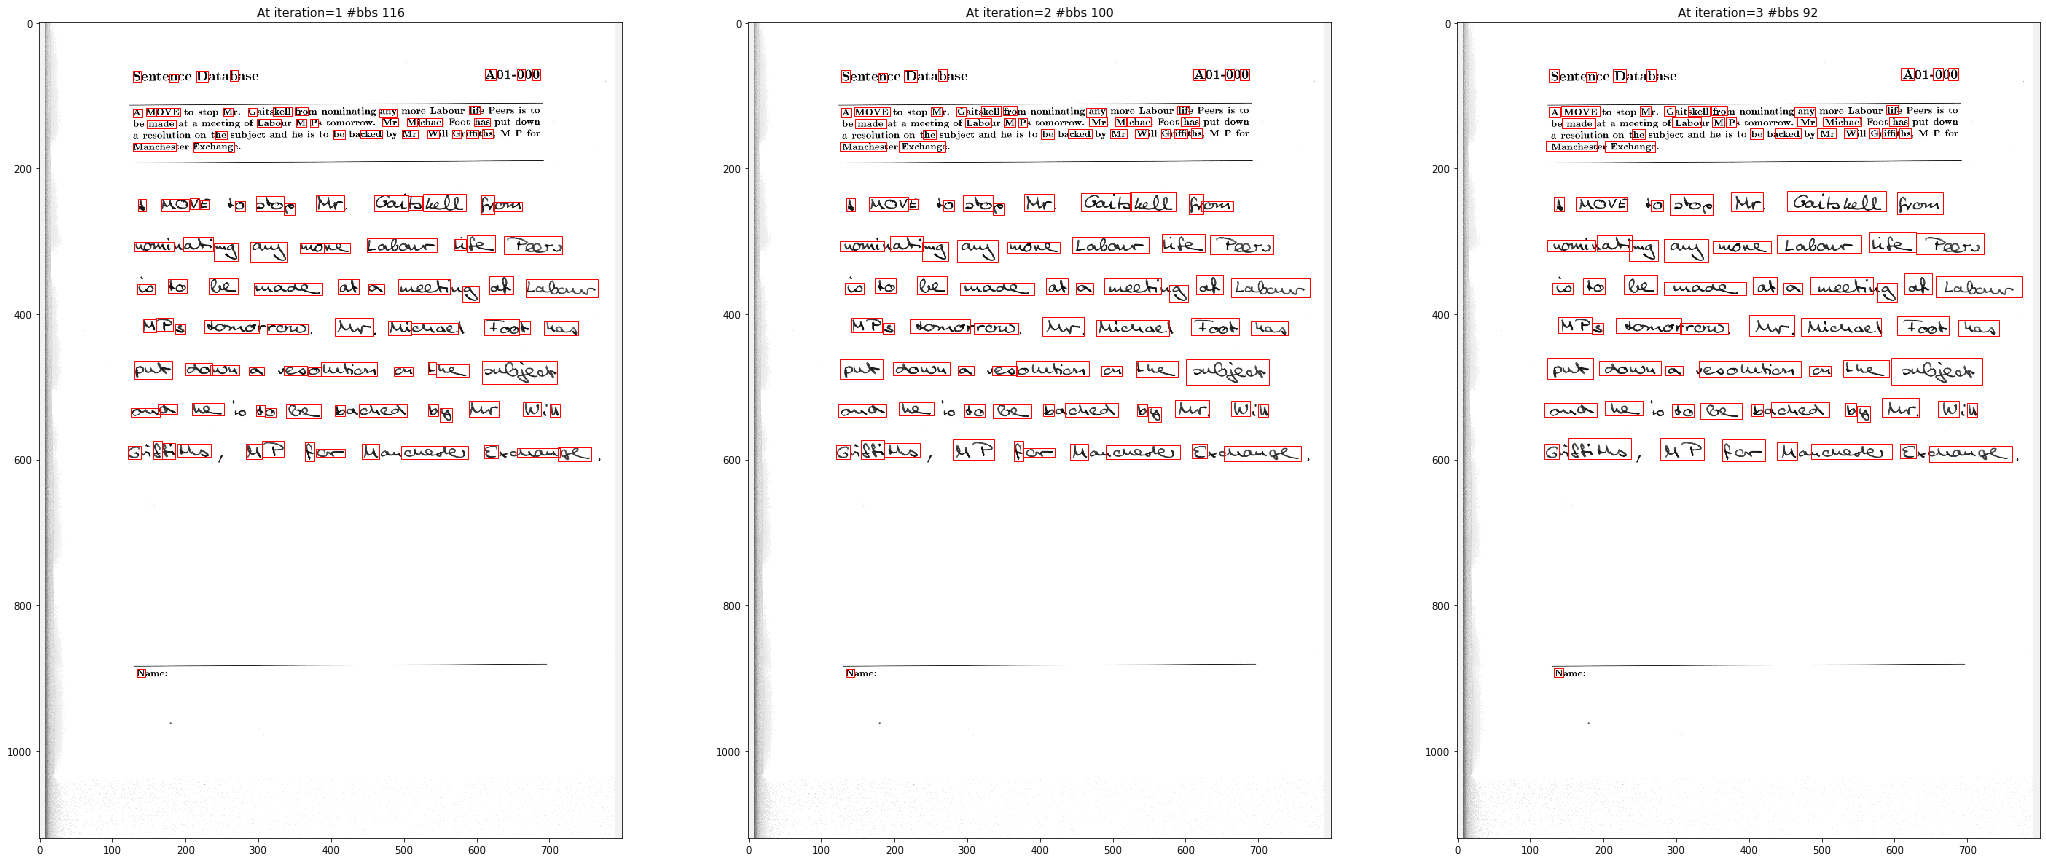

In [11]:
image, _ = train_ds[0]

iterations = 3
dilation_d = 1.1
dilation_max = (300, 300)
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
intermetiate_bbs = []
bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                      dilation_max, intermetiate_bbs)
plot_intermediate_bbs(intermetiate_bbs, iterations)

Running 0/4, new #bbs 103
Running 1/4, new #bbs 72
Running 2/4, new #bbs 24
Running 3/4, new #bbs 12


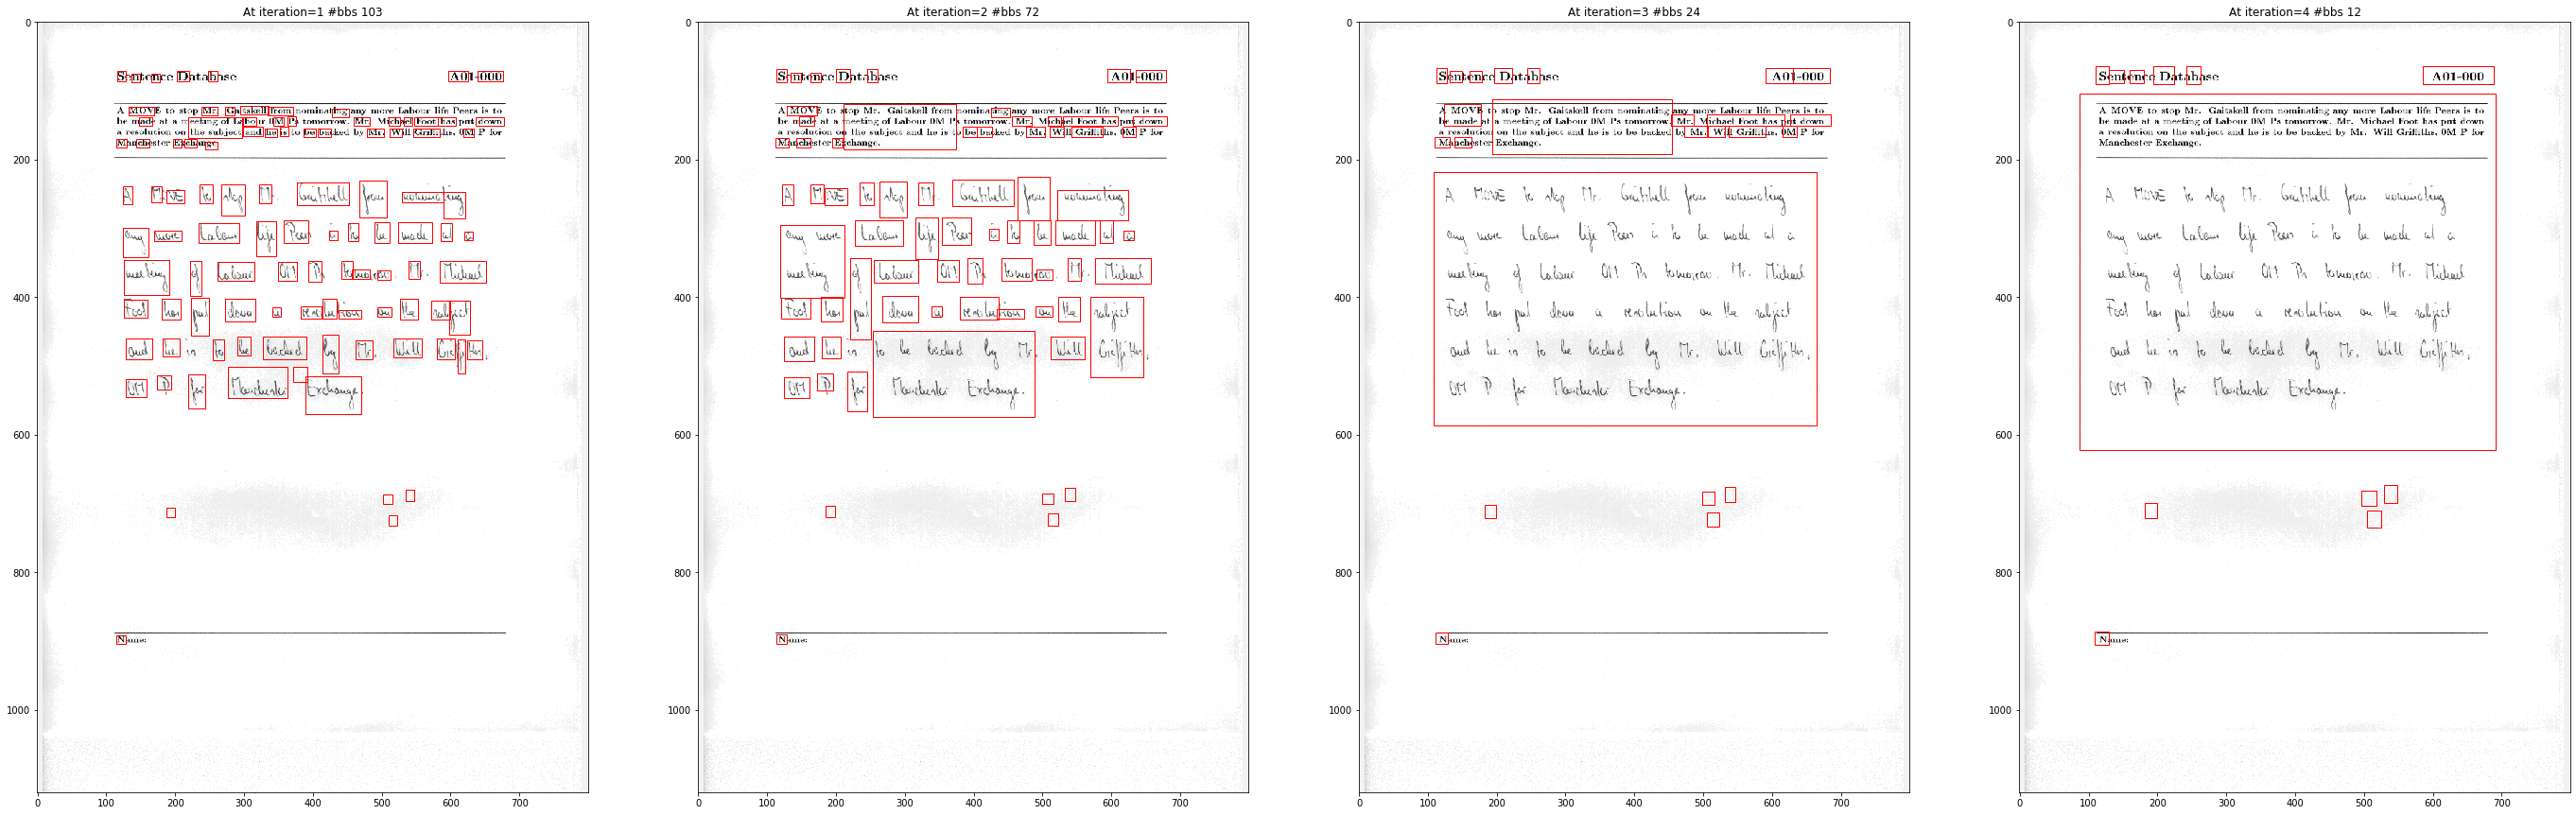

In [12]:
image, _ = train_ds[1]

iterations = 4
dilation_d = 1.2
dilation_max = (300, 300)
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
intermetiate_bbs = []
bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                      dilation_max, intermetiate_bbs)
plot_intermediate_bbs(intermetiate_bbs, iterations)

Running 0/5, new #bbs 68
Running 1/5, new #bbs 44
Running 2/5, new #bbs 34
Running 3/5, new #bbs 6
Running 4/5, new #bbs 6


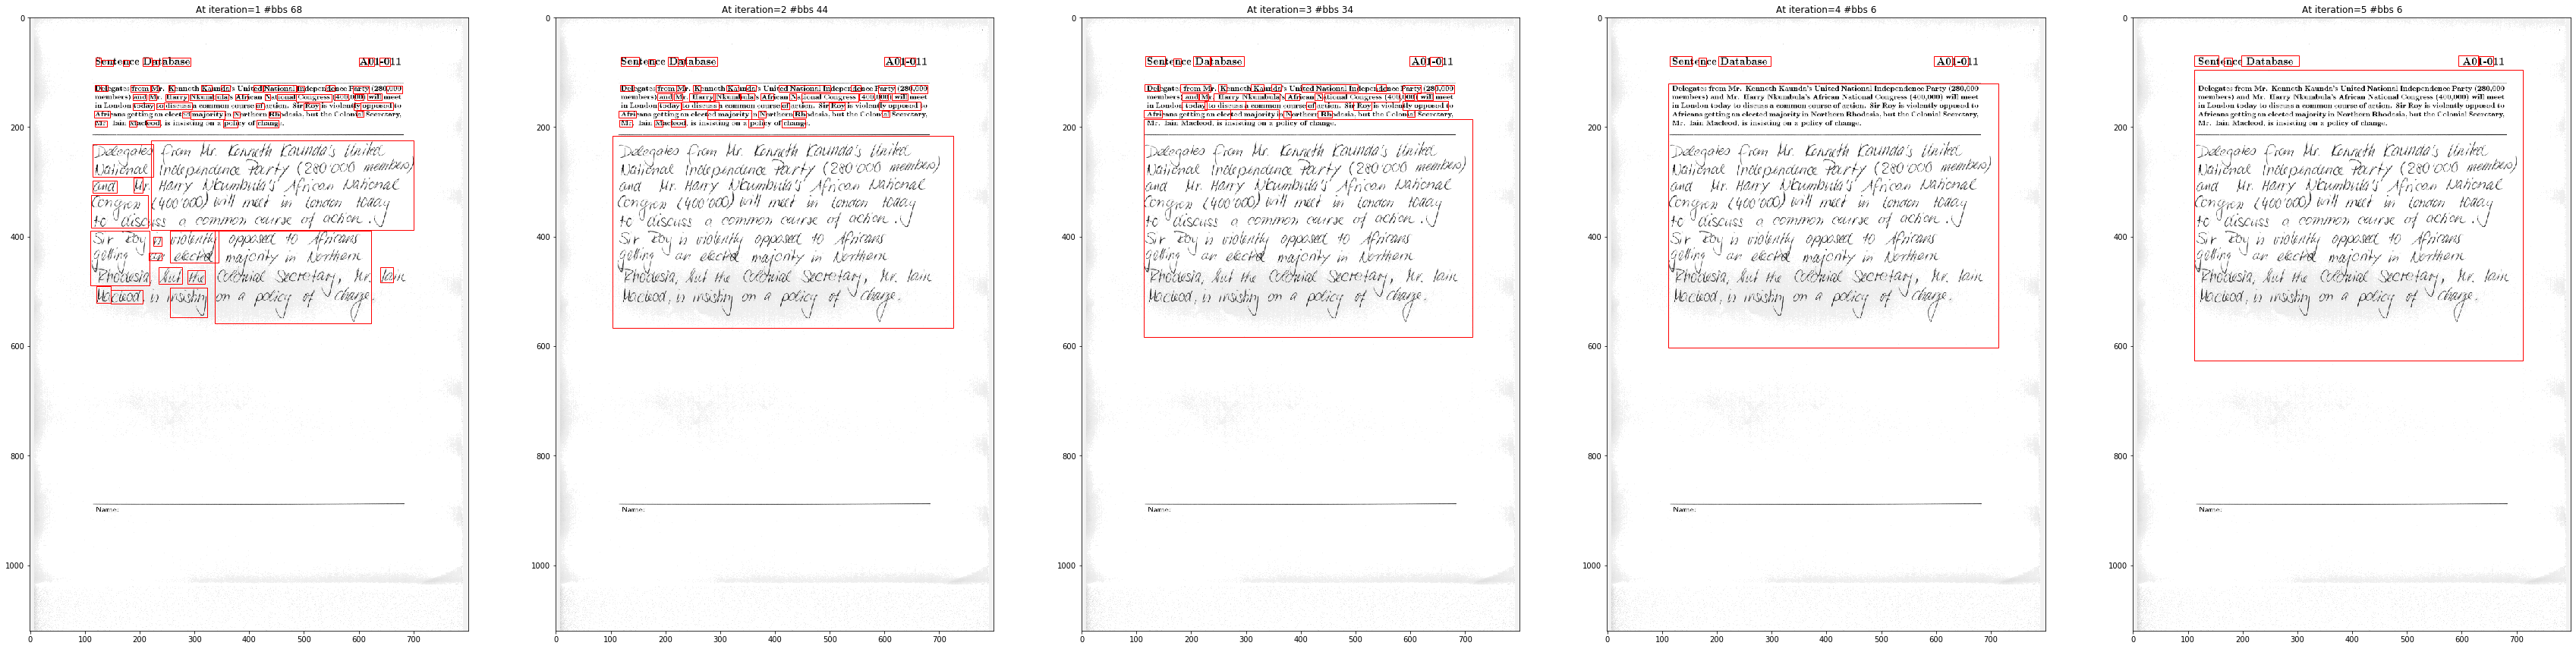

In [13]:
image, _ = train_ds[10]

iterations = 5
dilation_d = 1.1
dilation_max = (300, 300)
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
intermetiate_bbs = []
bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                      dilation_max, intermetiate_bbs)
plot_intermediate_bbs(intermetiate_bbs, iterations)

As shown in the examples, only the number of iterations and the ditation were changed between the three examples. The intersection threshold and the maximum dilation remained constant (0.1 and (300, 300) respectively). The example below shows a negative example when the parameters were not tuned for the image.

Running 0/5, new #bbs 111
Running 1/5, new #bbs 100
Running 2/5, new #bbs 88
Running 3/5, new #bbs 77
Running 4/5, new #bbs 36


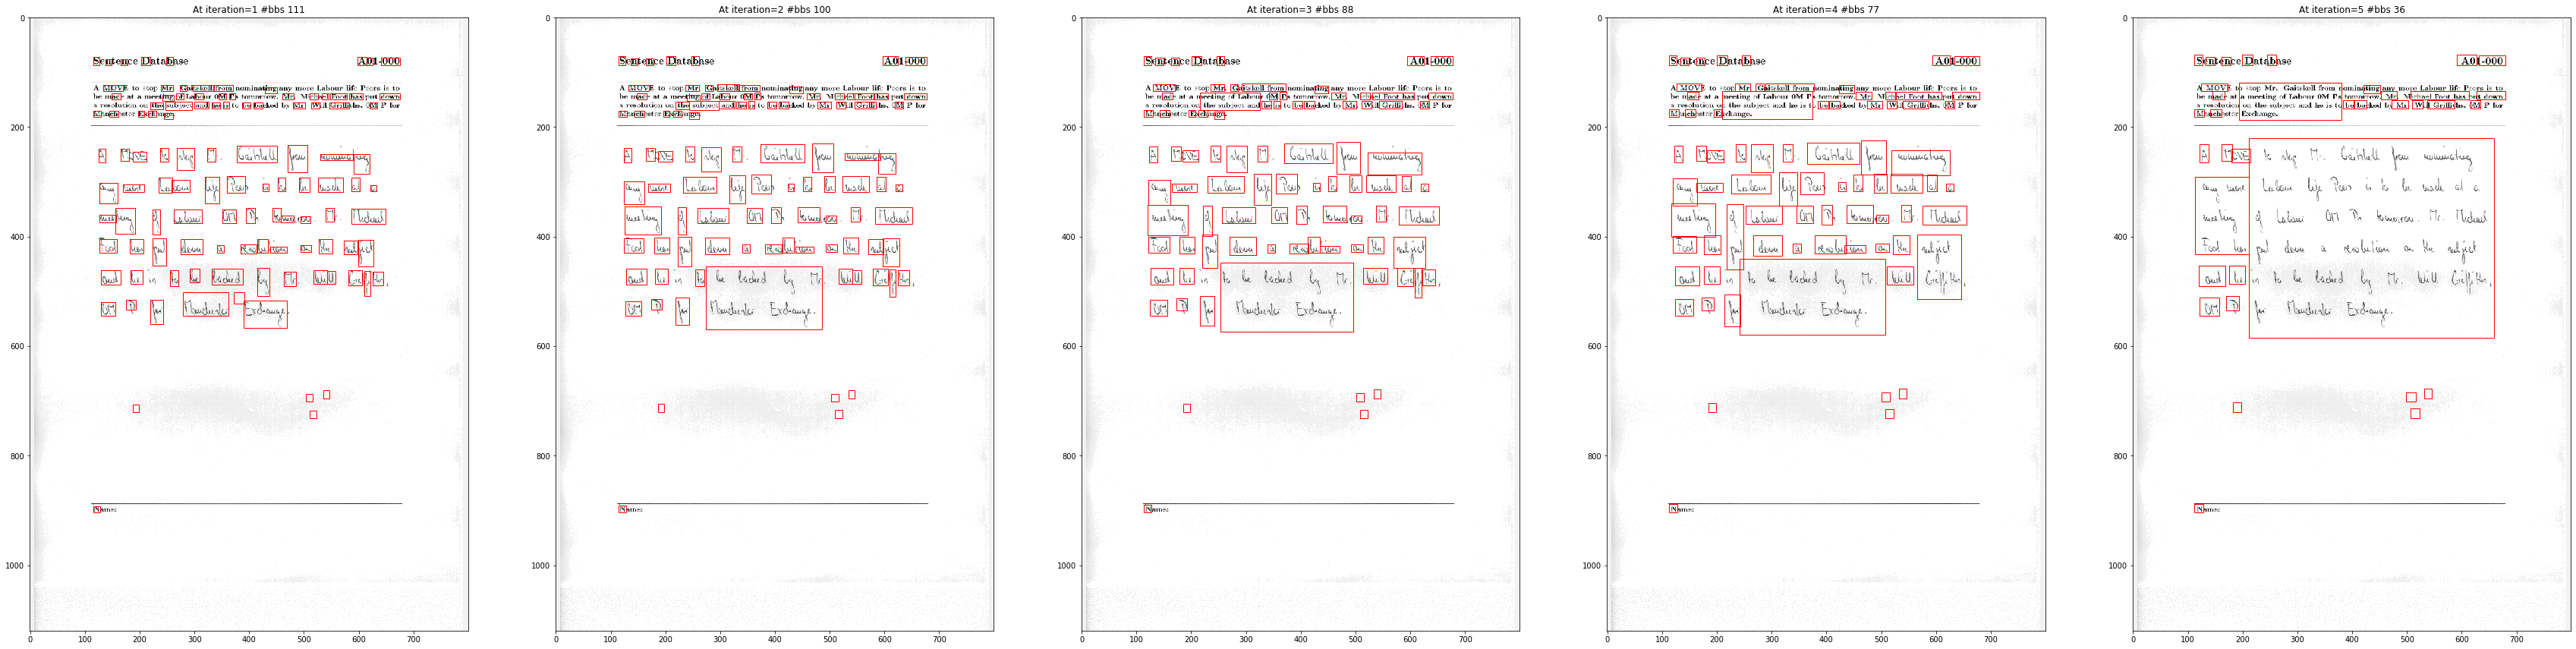

In [14]:
image, _ = train_ds[1]

iterations = 5
dilation_d = 1.1
dilation_max = (300, 300)
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
intermetiate_bbs = []
bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                      dilation_max, intermetiate_bbs)
plot_intermediate_bbs(intermetiate_bbs, iterations)

Using the parameters in Example 3 and applying it into the image in Example, we can observe that the region proposals hasn't merged yet.

This experiment may be suggesting that unlike printed text, handwritten text is more heterogeneous and changes very dramatically between the writers. The results suggest that using the MSERs algorithm for detecting handwritten passages doesn't very well between the handwritting of different subjects.

## References
[1] Chen, Huizhong, et al. "Robust text detection in natural images with edge-enhanced maximally stable extremal regions." Image Processing (ICIP), 2011 18th IEEE International Conference on. IEEE, 2011.